In [54]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from dowhy import gcm

# Setting up the graph

In [6]:
# Create node lookup for channels
node_lookup = {0: 'conversions',
               1: 'ppc clicks',
               2: 'seo clicks', 
               3: 'social clicks',
               4: 'direct clicks',
               5: 'ppc spend',               
               6: 'social spend',
               7: 'brand spend',
               8: 'demand'
 }

total_nodes = len(node_lookup)

# Create adjacency matrix - this is the base for our graph
graph_actual = np.zeros((total_nodes, total_nodes))

# Create graph using expert domain knowledge
graph_actual[1, 0] = 1.0 # ppc clicks -> conversions
graph_actual[2, 0] = 1.0 # seo clicks -> conversions
graph_actual[3, 0] = 1.0 # social clicks -> conversions
graph_actual[4, 0] = 1.0 # direct clicks -> conversions
graph_actual[1, 2] = 1.0 # ppc clicks -> conversions
graph_actual[5, 1] = 1.0 # ppc spend -> ppc clicks
graph_actual[6, 1] = 1.0 # social spend -> ppc clicks
graph_actual[6, 2] = 1.0 # social spend -> seo clicks
graph_actual[6, 3] = 1.0 # social spend -> social clicks
graph_actual[6, 4] = 1.0 # social spend -> direct clicks
graph_actual[7, 1] = 1.0 # brand spend -> ppc clicks
graph_actual[7, 2] = 1.0 # brand spend -> seo clicks
graph_actual[7, 3] = 1.0 # brand spend -> social clicks
graph_actual[7, 4] = 1.0 # brand spend -> direct clicks
graph_actual[8, 1] = 1.0 # demand -> ppc clicks
graph_actual[8, 2] = 1.0 # demand -> seo clicks
graph_actual[8, 3] = 1.0 # demand -> social clicks
graph_actual[8, 4] = 1.0 # demand -> direct clicks
     
graph_actual

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 0., 0., 0., 0.]])

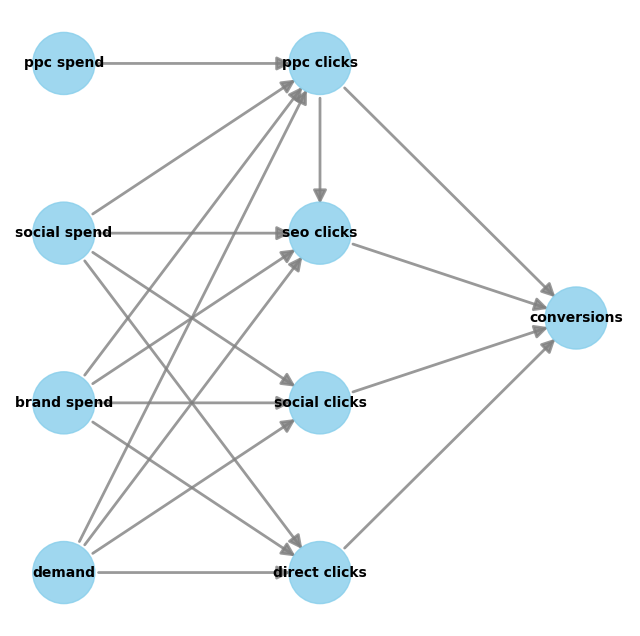

In [13]:
# Setup graph
graph = nx.from_numpy_array(graph_actual, create_using=nx.DiGraph)
graph = nx.relabel_nodes(graph, node_lookup)
gcm.util.plot(graph, figure_size=(8,8))

# Data generating process

<Axes: >

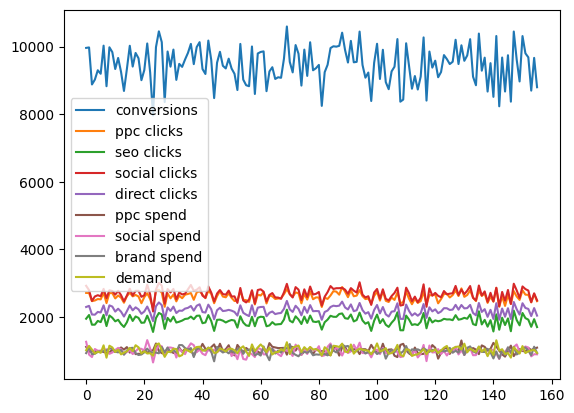

In [50]:
# Generate data
np.random.seed(999)

weeks = 156

df = pd.DataFrame(columns=node_lookup.values())

df['demand'] = np.random.normal(loc=1000, scale=100, size=weeks)
df['brand spend'] = np.random.normal(loc=1000, scale=100, size=weeks)
df['social spend'] = np.random.normal(loc=1000, scale=100, size=weeks)
df['ppc spend'] = np.random.normal(loc=1000, scale=100, size=weeks)
df['direct clicks'] = 0.9 * df['demand'] + 0.7 * df['brand spend'] + 0.5 * df['social spend'] + np.random.normal(loc=100, scale=10, size=weeks)
df['social clicks'] = 0.9 * df['demand'] + 0.7 * df['brand spend'] + 1.0 * df['social spend'] + np.random.normal(loc=100, scale=10, size=weeks)
df['seo clicks'] = 0.9 * df['demand'] + 0.7 * df['brand spend'] + 0.5 * df['social spend'] - 0.3 * df['ppc spend'] + np.random.normal(loc=100, scale=10, size=weeks)
df['ppc clicks'] = 0.9 * df['demand'] + 0.7 * df['brand spend'] + 0.5 * df['social spend'] + 0.4 * df['ppc spend'] + np.random.normal(loc=100, scale=10, size=weeks)
df['conversions'] = df['direct clicks'] + df['social clicks'] + df['seo clicks'] + df['ppc clicks'] + np.random.normal(loc=100, scale=10, size=weeks)

df.plot()

# Model

In [51]:
# Create SCM
causal_model = gcm.InvertibleStructuralCausalModel(graph)
causal_model.set_causal_mechanism('demand', gcm.EmpiricalDistribution()) # Root node
causal_model.set_causal_mechanism('brand spend', gcm.EmpiricalDistribution()) # Root node
causal_model.set_causal_mechanism('social spend', gcm.EmpiricalDistribution()) # Root node
causal_model.set_causal_mechanism('ppc spend', gcm.EmpiricalDistribution()) # Root node
causal_model.set_causal_mechanism('direct clicks', gcm.AdditiveNoiseModel(gcm.ml.create_ridge_regressor())) # Non-root node
causal_model.set_causal_mechanism('social clicks', gcm.AdditiveNoiseModel(gcm.ml.create_ridge_regressor())) # Non-root node
causal_model.set_causal_mechanism('seo clicks', gcm.AdditiveNoiseModel(gcm.ml.create_ridge_regressor())) # Non-root node
causal_model.set_causal_mechanism('ppc clicks', gcm.AdditiveNoiseModel(gcm.ml.create_ridge_regressor())) # Non-root node
causal_model.set_causal_mechanism('conversions', gcm.AdditiveNoiseModel(gcm.ml.create_ridge_regressor())) # Non-root node

gcm.fit(causal_model, df)

Fitting causal mechanism of node demand: 100%|██████████| 9/9 [00:00<00:00, 308.21it/s]


Test permutations of given graph: 100%|██████████| 50/50 [00:07<00:00,  6.76it/s]


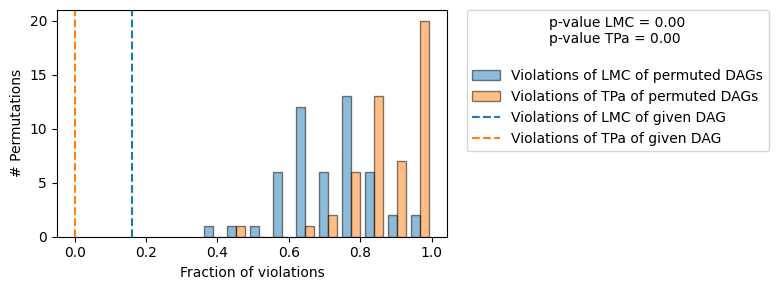

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [52]:
# Check model fit statistics
print(gcm.evaluate_causal_model(causal_model, df))

In [95]:
# Causal graph counterfactual
df_counterfactual = gcm.counterfactual_samples(causal_model, {'ppc spend': lambda x: 0}, observed_data=df)
round((df['conversions'].sum() - df_counterfactual['conversions'].sum()))

# Visualisations for blog

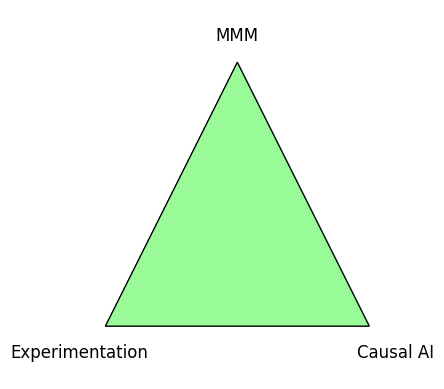

In [11]:
# Coordinates for the corners of the triangle
triangle_coords = [(0.5, 1), (0, 0), (1, 0)]

# Labels for the corners with adjusted positions
labels = [
    ('MMM', (0.5, 1.1)),  # Slightly above the top vertex
    ('Experimentation', (-0.1, -0.1)),  # Slightly below and to the left of the bottom-left vertex
    ('Causal AI', (1.1, -0.1))  # Slightly below and to the right of the bottom-right vertex
]

# Create a new figure
plt.figure()

# Plot the triangle with pastel green color
triangle = plt.Polygon(triangle_coords, fill=True, edgecolor='black', facecolor='palegreen')
plt.gca().add_patch(triangle)

# Plot the labels at the adjusted positions
for label, coord in labels:
    plt.text(coord[0], coord[1], label, fontsize=12, ha='center', va='center')

# Set the limits and aspect ratio
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.gca().set_aspect('equal', adjustable='box')

# Hide the axes
plt.axis('off')

# Show the plot
plt.show()

$$ \hat{Y} = \beta_0 + \beta_1 X_{1} + \beta_2 X_{2} + \ldots + \beta_n X_{n} + \epsilon $$

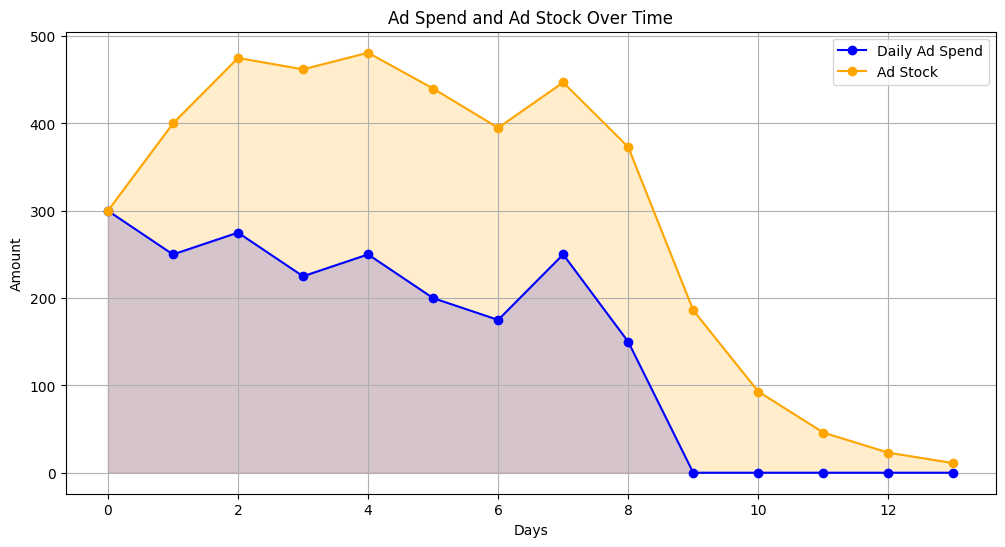

In [20]:
# Define parameters
decay_rate = 0.5  # Decay rate (between 0 and 1)
ad_spend = np.array([300, 250, 275, 225, 250, 200, 175, 250, 150, 0, 0, 0, 0, 0])  # Daily ad spend over two weeks

# Calculate ad stock
ad_stock = np.zeros_like(ad_spend)
for t in range(len(ad_spend)):
    if t == 0:
        ad_stock[t] = ad_spend[t]
    else:
        ad_stock[t] = ad_spend[t] + decay_rate * ad_stock[t - 1]

# Plot ad spend and ad stock
plt.figure(figsize=(12, 6))
plt.plot(ad_spend, marker='o', label='Daily Ad Spend', color='blue')
plt.plot(ad_stock, marker='o', label='Ad Stock', color='orange')
plt.fill_between(range(len(ad_spend)), 0, ad_spend, color='blue', alpha=0.2)
plt.fill_between(range(len(ad_spend)), 0, ad_stock, color='orange', alpha=0.2)

# Add labels and title
plt.xlabel('Days')
plt.ylabel('Amount')
plt.title('Ad Spend and Ad Stock Over Time')
plt.legend()
plt.grid(True)
plt.show()


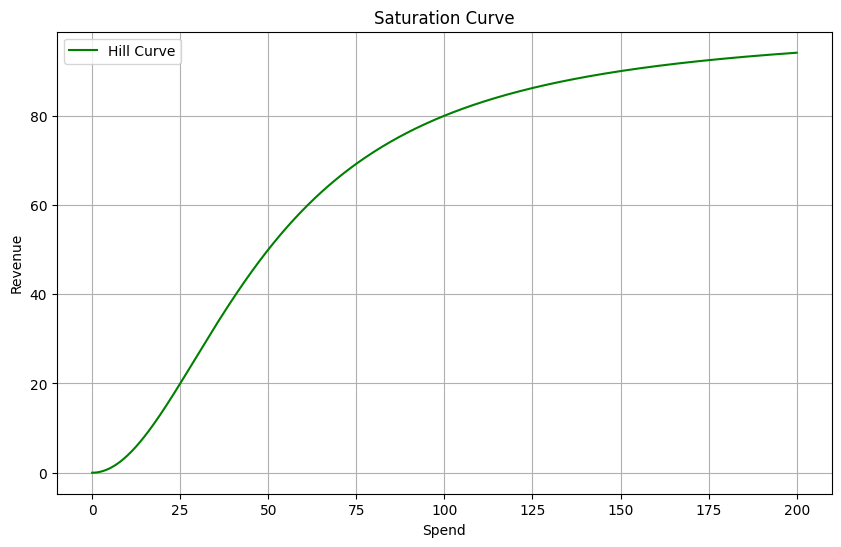

In [26]:
# Define the parameters for the Hill equation
V_max = 100  # Maximum response
K_d = 50     # Half-saturation constant
n = 2        # Hill coefficient

# Generate substrate concentration values
S = np.linspace(0, 200, 500)

# Calculate the response using the Hill equation
V = V_max * (S**n / (K_d**n + S**n))

# Plot the saturation curve (Hill equation)
plt.figure(figsize=(10, 6))
plt.plot(S, V, label=f'Hill Curve', color='g')
plt.xlabel('Spend')
plt.ylabel('Revenue')
plt.title('Saturation Curve')
plt.legend()
plt.grid(True)
plt.show()


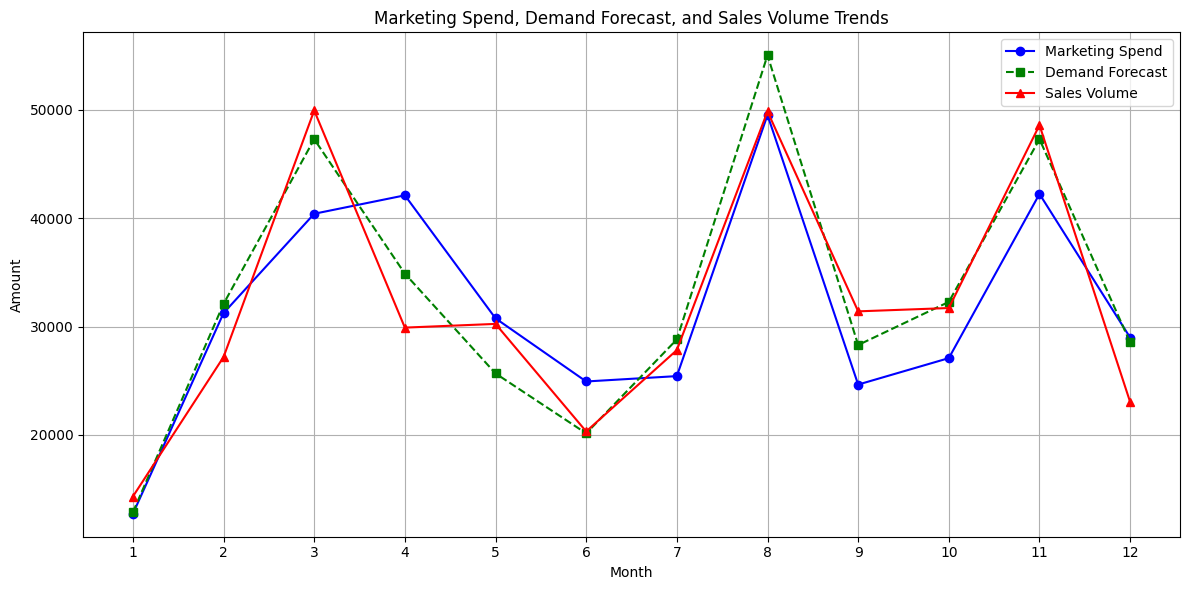

In [30]:
# Generate sample data (time series)
np.random.seed(0)
months = np.arange(1, 13)
marketing_spend = np.random.randint(10000, 50000, size=12)  # Random marketing spend data
demand_forecast = marketing_spend * np.random.uniform(0.8, 1.2, size=12)  # Demand forecast (influenced by marketing spend)
sales_volume = demand_forecast * np.random.uniform(0.8, 1.2, size=12)  # Sales volume (influenced by demand forecast)

# Plotting the time series data
plt.figure(figsize=(12, 6))

plt.plot(months, marketing_spend, marker='o', linestyle='-', color='b', label='Marketing Spend')
plt.plot(months, demand_forecast, marker='s', linestyle='--', color='g', label='Demand Forecast')
plt.plot(months, sales_volume, marker='^', linestyle='-', color='r', label='Sales Volume')

plt.xlabel('Month')
plt.ylabel('Amount')
plt.title('Marketing Spend, Demand Forecast, and Sales Volume Trends')
plt.xticks(months)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
